In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zyphyr69","key":"7713888d5e11109c8a40d05978cd8fc0"}'}

In [3]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
 99% 2.68G/2.70G [00:38<00:00, 73.1MB/s]
100% 2.70G/2.70G [00:38<00:00, 75.5MB/s]


In [6]:
!unzip new-plant-diseases-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/273a7a9e-18be-4b6a-976a-fa5ffd69b731___RS_HL 4366_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665_270deg.JPG  
  inflating: new plant diseases dataset(augmented)/New 

# Project Code

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
from PIL import Image
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import matplotlib.pyplot as plt
tf.compat.v1.set_random_seed(0)
from tensorflow import keras
import numpy as np
np.random.seed(0)
import itertools
from keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Data Loading

In [9]:
train_gen = image_dataset_from_directory(directory="/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train",
                                         image_size=(256, 256))
test_gen = image_dataset_from_directory(directory="/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid",
                                        image_size=(256, 256))

rescale = Rescaling(scale=1.0/255)
train_gen = train_gen.map(lambda image,label:(rescale(image),label))
test_gen  = test_gen.map(lambda image,label:(rescale(image),label))

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


# Data Engineering
Since the data is already augmented, there is no requirement of data engineering. Feature scaling is automatically done by image generators

# Modelling

In [ ]:
model = keras.Sequential()

model.add(keras.layers.Conv2D(32,(3,3),activation="relu",padding="same",input_shape=(256,256,3)))
model.add(keras.layers.Conv2D(32,(3,3),activation="relu",padding="same"))
model.add(keras.layers.MaxPooling2D(3,3))

model.add(keras.layers.Conv2D(64,(3,3),activation="relu",padding="same"))
model.add(keras.layers.Conv2D(64,(3,3),activation="relu",padding="same"))
model.add(keras.layers.MaxPooling2D(3,3))

model.add(keras.layers.Conv2D(128,(3,3),activation="relu",padding="same"))
model.add(keras.layers.Conv2D(128,(3,3),activation="relu",padding="same"))
model.add(keras.layers.MaxPooling2D(3,3))

model.add(keras.layers.Conv2D(256,(3,3),activation="relu",padding="same"))
model.add(keras.layers.Conv2D(256,(3,3),activation="relu",padding="same"))

model.add(keras.layers.Conv2D(512,(5,5),activation="relu",padding="same"))
model.add(keras.layers.Conv2D(512,(5,5),activation="relu",padding="same"))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(1568,activation="relu"))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(38,activation="softmax"))

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,loss="sparse_categorical_crossentropy",metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 85, 85, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 85, 85, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 85, 85, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 28, 28, 64)        0         
 g2D)                                                   

In [15]:
# Define the Capsule Layer
class CapsuleLayer(keras.layers.Layer):
    def __init__(self, num_capsules, capsule_dim, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsules = num_capsules
        self.capsule_dim = capsule_dim
        self.routings = routings
        self.kernel_initializer = tf.keras.initializers.get('glorot_uniform')

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W = self.add_weight(shape=[input_dim, self.num_capsules * self.capsule_dim],
                                 initializer=self.kernel_initializer,
                                 trainable=True)

    def call(self, inputs):
        # Transform input vectors with W
        votes = tf.matmul(inputs, self.W)

        # Reshape votes into capsules
        votes_shape = tf.shape(votes)
        votes = tf.reshape(votes, [votes_shape[0], votes_shape[1], self.num_capsules, self.capsule_dim])

        # Routing algorithm
        raw_weights = tf.zeros([votes_shape[0], votes_shape[1], self.num_capsules])
        for i in range(self.routings):
            routing_weights = tf.nn.softmax(raw_weights, axis=-1)
            weighted_votes = tf.einsum('bij,bijk->bik', routing_weights, votes)
            capsules = self.squash(weighted_votes)
            if i < self.routings - 1:
                agreement = tf.einsum('bik,bijk->bij', capsules, votes)
                raw_weights += agreement

        return capsules

    def squash(self, vectors):
        squared_norm = tf.reduce_sum(tf.square(vectors), axis=-1, keepdims=True)
        scale = squared_norm / (1 + squared_norm) / tf.sqrt(squared_norm + tf.keras.backend.epsilon())
        return scale * vectors

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsules, self.capsule_dim])

In [25]:
# Define the Capsule Network model
def create_capsule_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = CapsuleLayer(num_classes, 16)(x)  # Replace the final Conv2D layer with CapsuleLayer
    outputs = layers.Lambda(lambda x: tf.sqrt(tf.reduce_sum(tf.square(x), axis=-1)), output_shape=(num_classes,))(x)
    return keras.Model(inputs=inputs, outputs=outputs)

input_shape = (256, 256, 3)
num_classes = 38
model = create_capsule_model(input_shape, num_classes)

# Output the model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_13 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 conv2d_14 (Conv2D)          (None, 256, 256, 64)      18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 256, 256, 128)     73856     
                                                                 
 conv2d_16 (Conv2D)          (None, 256, 256, 256)     295168    
                                                                 
 capsule_layer_1 (CapsuleLa  (None, 256, 16)           155648    
 yer)                                                            
                                                           

In [ ]:
ep = 10
history = model.fit_generator(train_gen,
          validation_data=test_gen,
          epochs = ep)

Epoch 1/10
2197/2197 [==============================] - 373s 163ms/step - loss: 1.6700 - accuracy: 0.5086 - val_loss: 0.6028 - val_accuracy: 0.8076
Epoch 2/10
2197/2197 [==============================] - 376s 171ms/step - loss: 0.4636 - accuracy: 0.8520 - val_loss: 0.2887 - val_accuracy: 0.9030
Epoch 3/10
2197/2197 [==============================] - 377s 172ms/step - loss: 0.2696 - accuracy: 0.9121 - val_loss: 0.2282 - val_accuracy: 0.9248
Epoch 4/10
2197/2197 [==============================] - 358s 163ms/step - loss: 0.1858 - accuracy: 0.9385 - val_loss: 0.2046 - val_accuracy: 0.9340
Epoch 5/10
2197/2197 [==============================] - 359s 163ms/step - loss: 0.1387 - accuracy: 0.9539 - val_loss: 0.1247 - val_accuracy: 0.9604
Epoch 6/10
2197/2197 [==============================] - 378s 172ms/step - loss: 0.1074 - accuracy: 0.9639 - val_loss: 0.1305 - val_accuracy: 0.9573
Epoch 7/10
2197/2197 [==============================] - 359s 163ms/step - loss: 0.0850 - accuracy: 0.9709 - val_

In [ ]:
model.save("plant_disease.h5")

In [ ]:
#Save Model To GDrive
from tensorflow.keras.models import load_model
model.save('/content/drive/MyDrive/SavedModels/plant_disease.h5')

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/drive/MyDrive/SavedModels/plant_disease.h5')

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
import numpy as np
import tensorflow as tf
from PIL import Image

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="/content/model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load the image
image = Image.open("/content/test/test/AppleCedarRust1.JPG").convert("RGB")
image = image.resize((input_details[0]['shape'][1], input_details[0]['shape'][2]))

# Prepare input data
input_data = np.expand_dims(image, axis=0)
input_data = input_data.astype(np.float32)

# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run inference
interpreter.invoke()

# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])

# Process the output
prediction = np.argmax(output_data[0])

In [ ]:
prediction

4

# Metrics

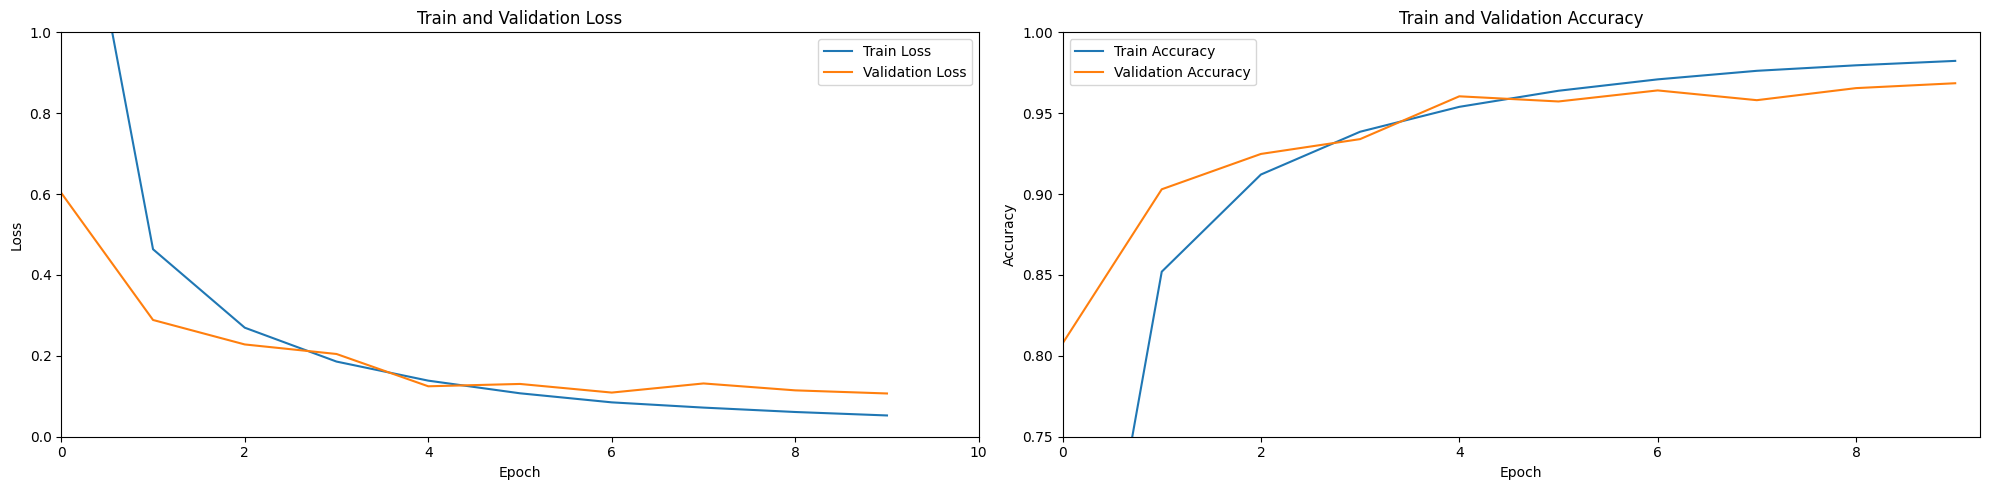

In [ ]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'],label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, 10)
plt.ylim(0.0,1.0)
plt.legend()

plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, 9.25)
plt.ylim(0.75,1.0)
plt.legend()
plt.tight_layout()

In [ ]:
labels = []
predictions = []
for x,y in test_gen:
    labels.append(list(y.numpy()))
    predictions.append(tf.argmax(model.predict(x),1).numpy())

1/1 [==============================] - 1s 925ms/step


In [ ]:
predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))

In [ ]:
print("Train Accuracy  : {:.2f} %".format(history.history['accuracy'][-1]*100))
print("Test Accuracy   : {:.2f} %".format(accuracy_score(labels, predictions) * 100))
print("Precision Score : {:.2f} %".format(precision_score(labels, predictions, average='micro') * 100))
print("Recall Score    : {:.2f} %".format(recall_score(labels, predictions, average='micro') * 100))

Train Accuracy  : 98.23 %
Test Accuracy   : 96.85 %
Precision Score : 96.85 %
Recall Score    : 96.85 %


# Confusion Matrix

<Figure size 2000x500 with 0 Axes>

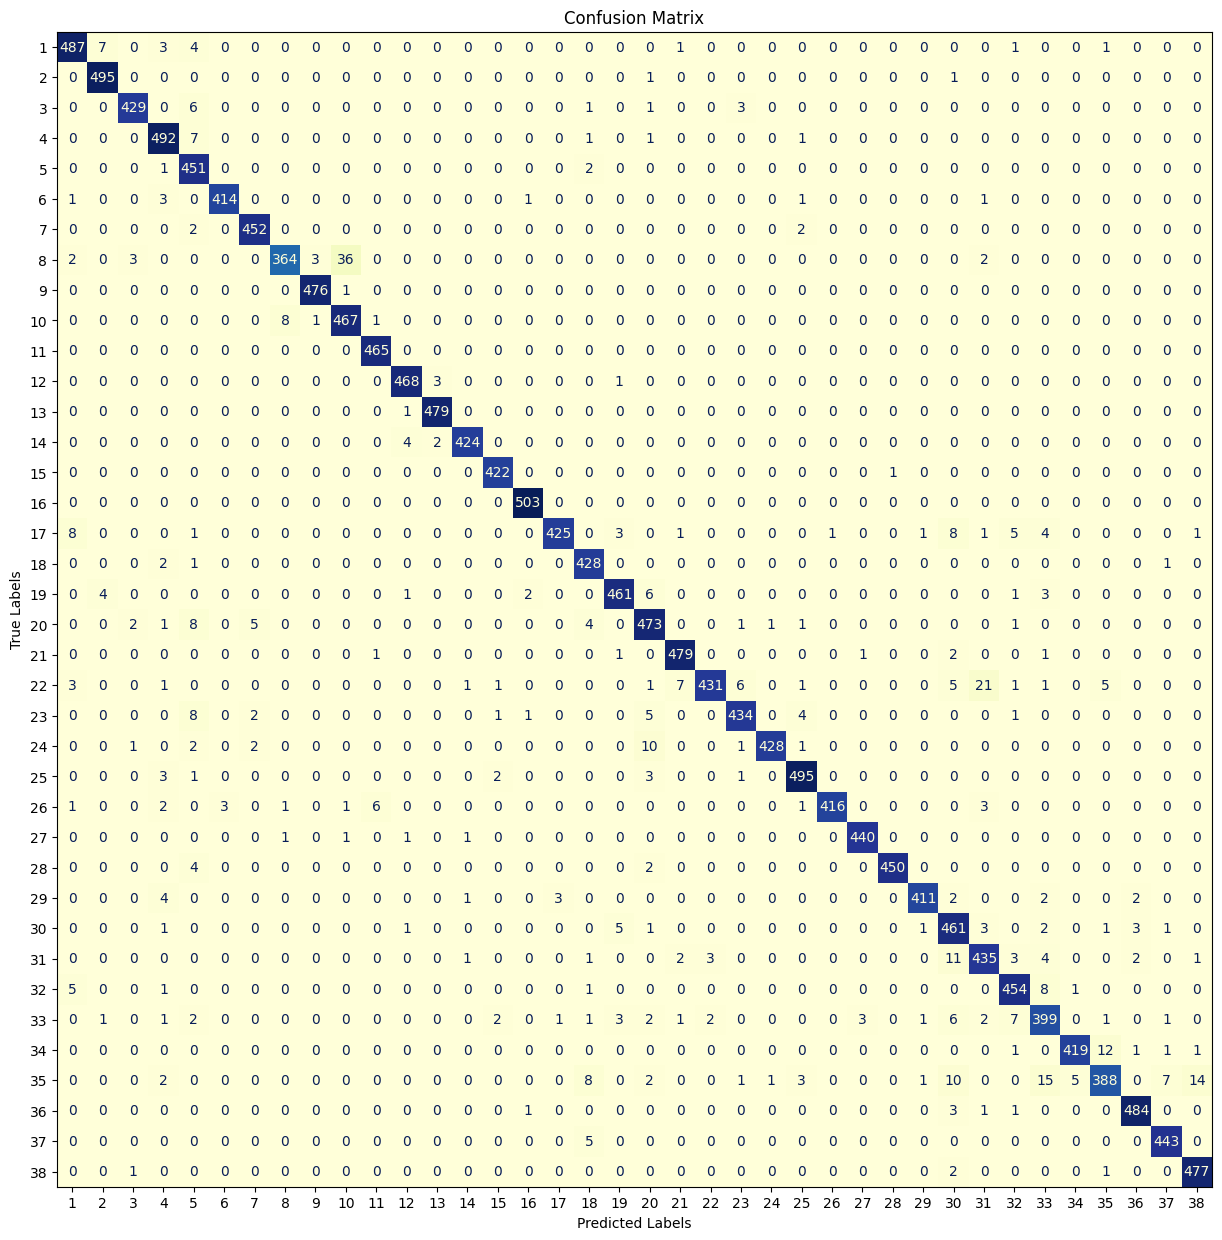

In [ ]:
plt.figure(figsize= (20,5))
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(range(1,39)))
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,colorbar= False,cmap = 'YlGnBu')
plt.title("Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

1/1 [==============================] - 0s 30ms/step
The leaf is of Tomato and its condition is  Late Blight


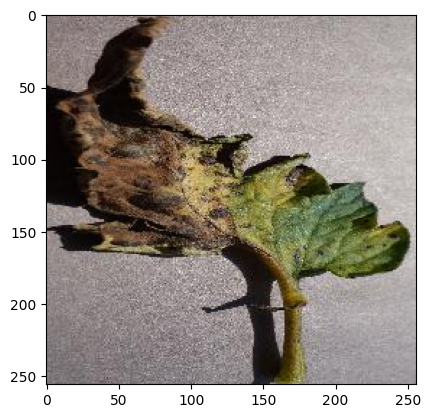

In [ ]:
# Set the path to the directory containing the dataset & load the Image
dataset_path = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
img_path = '/content/test/test/TomatoEarlyBlight1.JPG'
img = image.load_img(img_path, target_size=(256, 256))

# Preprocess the image
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

# Use the model to predict the class label
pred = model.predict(img_array)
class_label = np.argmax(pred)

# Get a list of all items (files and folders) in the dataset directory
items = os.listdir(dataset_path)

# Filter out only the folder names
folder_names = [item for item in items if os.path.isdir(os.path.join(dataset_path, item))]

# Sort the folder names alphabetically
folder_names.sort()

# Create a dictionary to map class labels to folder names
class_labels_mapping = {}

# Assign class labels to folder names
for index, folder_name in enumerate(folder_names):
    class_labels_mapping[index] = folder_name

# Use the model to predict the class label
pred = model.predict(img_array)
class_label = np.argmax(pred)
class_name = class_labels_mapping[class_label]

leaf_parts = class_name.split('_')
leaf_name = leaf_parts[0].title()

condition_parts = class_name.split('__')
condition = condition_parts[-1].replace('_', ' ').title()

output = f"The leaf is of {leaf_name} and its condition is {condition}"
print(output)

# Display the image

img = image.load_img(img_path, target_size=(256, 256))
plt.imshow(img)
plt.axis('on')
plt.show()

# Flask App And Website Implementation

In [ ]:
!pip install flask_ngrok

In [ ]:
!pip install pyngrok

In [ ]:
!ngrok authtoken 2aFwRSiEupMO3boGNrKjscVHpNQ_2BaNndxDMf37QrwvGh9Uc

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok

# Set up the ngrok tunnel
public_url = ngrok.connect(5000)

print(" * ngrok tunnel \"{}\" -> \"http://127.0.0.1:{}/\"".format(public_url, 5000))

 * ngrok tunnel "NgrokTunnel: "https://345e-35-230-127-10.ngrok-free.app" -> "http://localhost:5000"" -> "http://127.0.0.1:5000/"


In [ ]:
from flask import Flask, render_template, request, jsonify
from flask_ngrok import run_with_ngrok
from keras.preprocessing import image
import numpy as np
import os
from io import BytesIO

# Import your model and other necessary functions/classes
# Replace 'model' with the actual name of your model and adjust imports accordingly
model = tf.keras.models.load_model('/content/drive/MyDrive/SavedModels/plant_disease.h5')

app = Flask(__name__,)
run_with_ngrok(app)  # Start ngrok when the app is run

# Set the path to the directory containing the dataset
dataset_path = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"

# Get a list of all items (files and folders) in the dataset directory
items = os.listdir(dataset_path)

# Filter out only the folder names
folder_names = [item for item in items if os.path.isdir(os.path.join(dataset_path, item))]

# Sort the folder names alphabetically
folder_names.sort()

# Create a dictionary to map class labels to folder names
class_labels_mapping = {}

# Assign class labels to folder names
for index, folder_name in enumerate(folder_names):
    class_labels_mapping[index] = folder_name

# Route for the main page
@app.route('/')
def index():
    return render_template('Home.html')

@app.route('/plant-disease-detector')
def plant_disease_detector():
    return render_template('Plant-Disease-Detector.html')

# Route for plant disease detection
@app.route('/detect_disease', methods=['POST'])
def detect_disease_route():
    try:
        # Assuming you receive an image file in the request
        image_file = request.files['image']

        # Read the contents of the file
        img_contents = image_file.read()

        # Load and preprocess the image
        img = image.load_img(BytesIO(img_contents), target_size=(256, 256))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.

        # Use the model to predict the class label
        pred = model.predict(img_array)
        class_label = np.argmax(pred)
        class_name = class_labels_mapping[class_label]

        leaf_parts = class_name.split('_')
        leaf_name = leaf_parts[0].title()

        condition_parts = class_name.split('__')
        condition = condition_parts[-1].replace('_', ' ').title()

        output = f"The leaf is of {leaf_name} and its condition is {condition}"

        # Print for debugging
        print("Prediction:", output)

        # Return the result as JSON
        return jsonify({'result': output})

    except Exception as e:
        print(f"Exception: {e}")
        return jsonify({'error': 'Internal Server Error'}), 500

if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://345e-35-230-127-10.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [10/May/2024 20:18:53] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/May/2024 20:18:54] "GET /static/Home.css HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/May/2024 20:18:54] "GET /static/nicepage.css HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/May/2024 20:18:54] "GET /static/nicepage.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/May/2024 20:18:54] "GET /static/jquery.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/May/2024 20:18:54] "GET /static/images/tomato.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/May/2024 20:18:54] "GET /static/images/potato2.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/May/2024 20:18:54] "GET /static/images/download-PhotoRoom.png-PhotoRoom.png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/May/2024 20:18:54] "GET /static/images/corn2.jpeg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/May/2024 20:18:54] "GET /static/images/corn.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/May/2024 20:18: